Final Assets: 675579.4719999995 Total Return: 175579.47199999948 Return Rate: 35.115894399999895 %


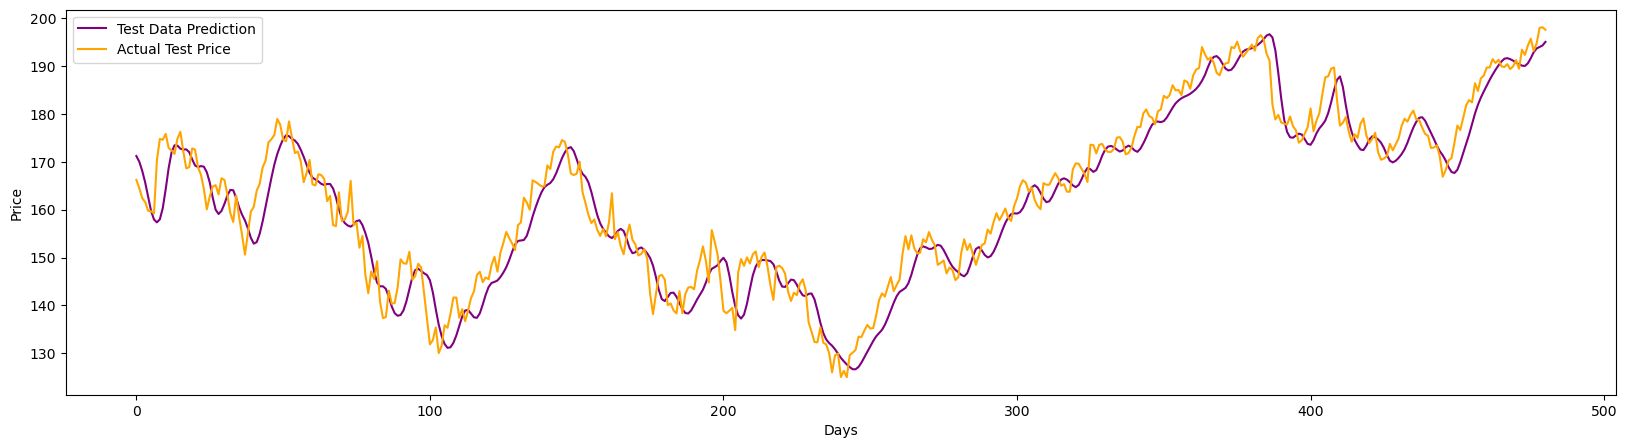

In [2]:
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 数据预处理函数
def prepare_data(df, window, features):
    scaler = MinMaxScaler()
    df_features = df[features]
    df_features_scaled = scaler.fit_transform(df_features)
    scaler_target = MinMaxScaler()
    df_target_scaled = scaler_target.fit_transform(df[['Close']])

    x, y = [], []
    for i in range(len(df_features_scaled) - window):
        x.append(df_features_scaled[i:i+window, :])
        y.append(df_target_scaled[i + window, 0])

    return np.array(x), np.array(y), scaler, scaler_target


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
# 加载新的数据
new_data_path = r'C:\Users\John\Desktop\学习课件\数据科学开源工具\作业\final project\AAPL_test.csv'  # 修改为你的新数据路径
new_data = pd.read_csv(new_data_path)

# 选择的特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# 使用与训练时相同的方式进行预处理
window = 20
x_val, y_val, scaler_new_features, scaler_target_new_features = prepare_data(new_data, window, features)


# 转换为 PyTorch 张量
x_val_torch = torch.from_numpy(x_val).type(torch.Tensor)
y_val_torch = torch.from_numpy(y_val).type(torch.Tensor)

# 创建一个新的 LSTM 模型实例
input_dim = len(features)
hidden_dim = 128
num_layers = 5
output_dim = 1  # 修改为之前保存模型时的输出维度
loaded_model = LSTM(input_dim, hidden_dim, num_layers, output_dim)

# 加载保存的模型参数
loaded_model.load_state_dict(torch.load('model.pth'))
# 设置模型为评估模式
loaded_model.eval()
y_val_pred = loaded_model(x_val_torch)
y_val_pred = scaler_target_new_features.inverse_transform(y_val_pred.detach().numpy())
y_val_actual = scaler_target_new_features.inverse_transform(y_val.reshape(-1, 1))

# 回测函数
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    cash = initial_cash
    shares = 0
    total_assets = initial_cash

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]

        if predicted_change > threshold and cash >= original_prices[i]:
            shares_bought = cash // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]
        elif predicted_change < -threshold and shares > 0:
            cash += shares * original_prices[i]
            shares = 0
        total_assets = cash + shares * original_prices[i]

    total_return = total_assets - initial_cash
    return total_assets, total_return


initial_cash = 500000
threshold = 0.015

# 应用回测函数
final_assets, total_return = backtest(y_val_pred[:, 0], y_val_actual[:, 0], threshold=threshold, initial_cash=initial_cash)

# 计算回报率
return_rate = (total_return / initial_cash) * 100

print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:", return_rate, "%")

# 可视化结果
N_test = len(y_val_pred)
index_test = np.array([i for i in range(0, N_test)]).reshape(-1, 1)

plt.figure(figsize=(20, 5))
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(index_test, y_val_pred, color='purple', label='Test Data Prediction')
plt.plot(index_test, y_val_actual, color='orange', label='Actual Test Price')
plt.legend()
plt.savefig("Test-Result.png", dpi=500)
plt.show()